In [1]:
import json
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
import nltk

In [2]:
# import relevant LMs package

import transformers
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, DataLoader, random_split
from transformers import BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import f1_score, accuracy_score


In [3]:
# cheak to use gpu or cpu
if torch.cuda.is_available():
    print("Use gpu")
    device = torch.device("cuda")
else:
    print("Use cpu")
    device = torch.device("cpu")

Use cpu


## KG

In [4]:
# KGs

import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [5]:
import csv
# import wikipedia sentences
import os

cwd = os.getcwd()  # Get the current working directory (cwd)
files = os.listdir(cwd)  # Get all the files in that directory
print("Files in %r: %s" % (cwd, files))

candidate_sentences = pd.read_csv("/Users/wz/IdeaProjects/context-aware-embedding/Resources/code/input/wiki_sentences_v2.csv")
candidate_sentences.shape

Files in '/Users/wz/IdeaProjects/context-aware-embedding/Resources/code': ['Messing around.ipynb', '.DS_Store', 'input', '.ipynb_checkpoints', 'wandb']


(4318, 1)

In [6]:
candidate_sentences['sentence'].sample(5)

2189    over time, however, the film's reputation has improved greatly.
1572                              he became known as india's paul muni.
2819                                      you've never seen her before.
1287                             on may 28, 2016, filming was complete.
2575                however, talks between the studios then broke down.
Name: sentence, dtype: object

In [7]:
doc = nlp("the drawdown process is governed by astm standard d823")

for tok in doc:
    print(tok.text, "...", tok.dep_)

the ... det
drawdown ... compound
process ... nsubjpass
is ... auxpass
governed ... ROOT
by ... agent
astm ... compound
standard ... pobj
d823 ... punct


In [8]:
def get_entities(sent):
## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [9]:
get_entities("the film had 200 patents")

['film', '200  patents']

In [10]:
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████████████████████████████████| 4318/4318 [00:20<00:00, 207.16it/s]


In [11]:
entity_pairs[10:20]

[['we', 'tests'],
 ['m', 'international sales rights'],
 ['canadian musician robbie robertson', 'soundtrack'],
 ['it', 'original music tracks'],
 ['it', 'reviewed  franchise'],
 ['she', 'accidentally  mystique'],
 ['military  forces', 'arrest'],
 ['train', 'vuk'],
 ['kota eberhardt', 'telepath selene gallio'],
 ['singer', 'sequel']]

In [12]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1",[pattern],on_match=None ) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [13]:
get_relation("John completed the task")

'completed'

In [14]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]

100%|██████████████████████████████████████| 4318/4318 [00:19<00:00, 217.00it/s]


In [15]:
pd.Series(relations).value_counts()[:50]

is               356
was              293
released on       85
\n                80
are               68
were              68
include           68
                  50
released          41
's                36
became            32
have              31
has               28
released in       27
become            26
composed by       23
called            23
included          23
considered        21
been              20
had               20
used              18
made              18
produced          18
be                16
directed by       16
hired             14
received          13
introduced in     13
went              13
produced by       13
wrote             13
set               13
written by        12
scheduled         12
began in          11
cast as           11
began             11
wanted            11
won               11
stars             11
directed          10
sold              10
gave              10
includes          10
opened             9
used in            9
said         

In [16]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})



In [17]:
kg_df

,source,target,edge
0,connie,own,decides
1,later scream,distance,heard in
2,christian,then elder,paralyzed by
3,temple,fire,set on
4,,outside cult him,wails with
...,...,...,...
4313,confidencial,negatively film,responded
4314,le parisien,five star rating,gave
4315,museum collection,"37,000 film titles",includes
4316,predecessor,historical film 1946,was


In [18]:
def contains(source, target, relations):
    triple = np.array([source, target, relations])
    return (kg_df==triple).all(1).any()

contains("connie", "own",  "decides")

True

In [19]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

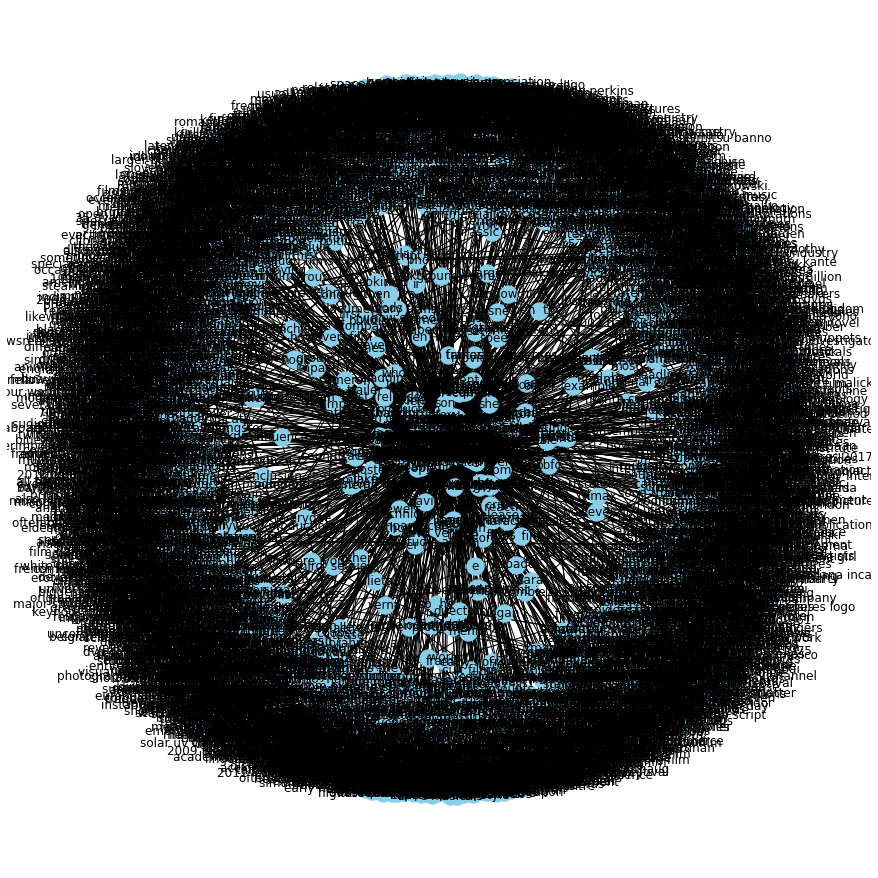

In [20]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

## LM

In [21]:
%load_ext autoreload
%autoreload 2

import torch
import wandb
import time
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
from random import choices
import matplotlib.pyplot as plt
tqdm.pandas()

from datasets import load_dataset

from transformers import GPT2Tokenizer
from transformers import AutoModelForSequenceClassification, AutoTokenizer

from trl.gpt2 import GPT2HeadWithValueModel, respond_to_batch
from trl.ppo import PPOTrainer
from trl.core import build_bert_batch_from_txt

config = {
    "lm_name": "lvwerra/gpt2-imdb",
    "ref_lm_name": "lvwerra/gpt2-imdb",
    "cls_model_name": "lvwerra/distilbert-imdb",
    "tk_name": "gpt2",
    "steps": 51200,
    "batch_size": 256,
    "forward_batch_size": 32,
    "ppo_epochs": 4,   
    "txt_in_len": 5,
    "txt_out_len": 20,
    "lr": 1.41e-5,
    "init_kl_coef":0.2,
    "target": 6,
    "horizon":10000,
    "gamma":1,
    "lam":0.95,
    "cliprange": .2,
    "cliprange_value":.2,
    "vf_coef":.1, 
    "seed": 1,
}

np.random.seed(config['seed'])


In [22]:
# trails
wandb.init(name='trails #1', project='gpt2-ctrl', config=config)

wandb: Currently logged in as: wz_ryan (use `wandb login --relogin` to force relogin)


### Load pre-trained GPT2 language models

In [23]:
gpt2_model = GPT2HeadWithValueModel.from_pretrained(config['lm_name'])
gpt2_model_ref = GPT2HeadWithValueModel.from_pretrained(config['ref_lm_name'])
gpt2_tokenizer = GPT2Tokenizer.from_pretrained(config['tk_name'])

Some weights of GPT2HeadWithValueModel were not initialized from the model checkpoint at lvwerra/gpt2-imdb and are newly initialized: ['transformer.h.0.attn.masked_bias', 'transformer.h.1.attn.masked_bias', 'transformer.h.2.attn.masked_bias', 'transformer.h.3.attn.masked_bias', 'transformer.h.4.attn.masked_bias', 'transformer.h.5.attn.masked_bias', 'transformer.h.6.attn.masked_bias', 'transformer.h.7.attn.masked_bias', 'transformer.h.8.attn.masked_bias', 'transformer.h.9.attn.masked_bias', 'transformer.h.10.attn.masked_bias', 'transformer.h.11.attn.masked_bias', 'v_head.summary.weight', 'v_head.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of GPT2HeadWithValueModel were not initialized from the model checkpoint at lvwerra/gpt2-imdb and are newly initialized: ['transformer.h.0.attn.masked_bias', 'transformer.h.1.attn.masked_bias', 'transformer.h.2.attn.masked_bias', 'transformer.h.3.attn.masked_

In [24]:
_ = gpt2_model.to(device)
_ = gpt2_model_ref.to(device)

In [25]:
wandb.watch(gpt2_model, log='all')

[]

### Next Token Prediction with GPT2

In [26]:
from transformers import AutoModelForCausalLM, AutoTokenizer


print("\nBegin next-word using HF GPT-2 demo ")

toker = AutoTokenizer.from_pretrained("gpt2")
model = AutoModelForCausalLM.from_pretrained("gpt2")


Begin next-word using HF GPT-2 demo 


In [27]:
seq = "connie own"
print("\nInput sequence: ")
print(seq)

inpts = toker(seq, return_tensors="pt")
print("\nTokenized input data structure: ")
print(inpts)

inpt_ids = inpts["input_ids"]  # just IDS, no attn mask
print("\nToken IDs and their words: ")
for id in inpt_ids[0]:
    word = toker.decode(id)
    print(id, word)

    
with torch.no_grad():
    logits = model(**inpts).logits[:, -1, :]

print("\nAll logits for next word: ")
print(logits)
print(logits.shape)

pred_id = torch.argmax(logits).item()
print("\nPredicted token ID of next word: ")
print(pred_id)

pred_word = toker.decode(pred_id)
print("\nPredicted next word for sequence: ")
print(pred_word)



Input sequence: 
connie own

Tokenized input data structure: 
{'input_ids': tensor([[ 1102, 11952,   898]]), 'attention_mask': tensor([[1, 1, 1]])}

Token IDs and their words: 
tensor(1102) con
tensor(11952) nie
tensor(898)  own

All logits for next word: 
tensor([[-86.0371, -81.7704, -89.6549,  ..., -93.6331, -92.7520, -87.4399]])
torch.Size([1, 50257])

Predicted token ID of next word: 
262

Predicted next word for sequence: 
 the


In [28]:
def GPT_pred(seq):
    inpts = toker(seq, return_tensors="pt")
    inpt_ids = inpts["input_ids"]  # just IDS, no attn mask
        

    with torch.no_grad():
        logits = model(**inpts).logits[:, -1, :]
    pred_id = torch.argmax(logits).item()
    pred_word = toker.decode(pred_id)
    return logits, pred_id, pred_word
    

In [29]:
def pos_logit_to_reward(logit, task):
    """
    Take the positive sentiment logit and scale it for the task.
        task [negative]: reward = -logit
        task [positive]: reward = logit
    """
    for i in range(len(logit)):
        if task[i]=='[false]':
            logit[i] = -logit[i]
        elif task[i]=='[true]':
            pass
        else:
            raise ValueError('task has to be in [0, 1, 2]!')
    return logit

In [30]:
df = kg_df[:1000]

# modify query as object + relation
# e.g connie owns 
df['query'] = df.apply(
    lambda row: row.source + ' ' + row.edge, axis=1)
# adjust format in list 
df['query'] = [df['query'][i].split()[:2] for i in range(1000)]
df['query'] = df['query'].apply(lambda x: ' '.join(x))

#special token
df['tokens'] = df['query'].apply(lambda x: gpt2_tokenizer.encode(' '+str(x), return_tensors="pt").to(device))
df['tokens'] = df['tokens'].apply(lambda x: x[0])
df['tokens'] = df['tokens'].apply(lambda x: x[:2])

for i in range(1000):
    if len(df['tokens'].loc[i]) < 2:
        df['tokens'].loc[i] = df['tokens'].loc[0]
# df.loc[(len(df['tokens']) < 2), 'tokens'] = df['tokens'].loc[0]
#df['tokens'] = df['tokens'].apply(lambda x: df['tokens'].loc[0] if len(x) < 2)



ctrl_str = ['[false]', '[true]']
ctrl_tokens = dict((s, gpt2_tokenizer.encode(s, return_tensors="pt").squeeze().to(device)) for s in ctrl_str)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [31]:
df

,source,target,edge,query,tokens
0,connie,own,decides,connie decides,"[tensor(369), tensor(11952)]"
1,later scream,distance,heard in,later scream,"[tensor(1568), tensor(8196)]"
2,christian,then elder,paralyzed by,christian paralyzed,"[tensor(33826), tensor(666)]"
3,temple,fire,set on,temple set,"[tensor(12505), tensor(900)]"
4,,outside cult him,wails with,wails with,"[tensor(266), tensor(1768)]"
...,...,...,...,...,...
995,women,films,are,women are,"[tensor(1466), tensor(389)]"
996,earliest mystery films,silent era,reach,earliest mystery,"[tensor(14555), tensor(10715)]"
997,film,more 1953,remade,film remade,"[tensor(2646), tensor(816)]"
998,two films,now 1909,made in,two films,"[tensor(734), tensor(7328)]"


### PPO & Optimization

In [ ]:
respond_to_batch(gpt2_model, df['token'].,
                                     txt_len=config['txt_out_len'])

In [32]:
ppo_trainer = PPOTrainer(gpt2_model, gpt2_model_ref, **config)
fbs = config['forward_batch_size']

for epoch in tqdm(range(int(np.ceil(config["steps"]/config['batch_size'])))):
    torch.cuda.empty_cache()
    logs = dict()
    game_data = dict()
    timing = dict()
    t0 = time.time()
    
    #### get a batch from the dataset and annotate tasks
    df_batch = df.sample(config['batch_size'])
    task_list = choices(ctrl_str, k=config['batch_size'])
    task_tensors = torch.stack([ctrl_tokens[t] for t in task_list])
    query_list = df_batch['query'].tolist()
    game_data['query'] = [t+q for t,q in zip(task_list, query_list)]
    
    query_tensors = torch.stack(df_batch['tokens'].tolist())
    query_tensors = torch.cat((task_tensors, query_tensors), axis=1)
    
#     print(query_tensors.size())
#     print(i)
#     logits = query_tensors[i*fbs:(i+3)*fbs]
#     print(logits)
#     pred_id = torch.argmax(logits).item()
#     print(pred_id)
#     #query = gpt2_tokenizer.decode(query_tensors[i*fbs:(i+1)*fbs])
#     respond = gpt2_tokenizer.decode(pred_id)
#     #print(query)
#     print(respond)
#     break
    
    #### get response from gpt2
    t = time.time()
    response_tensors = []
    for i in range(int(config['batch_size']/fbs)):
        response  = respond_to_batch(gpt2_model, query_tensors[i*fbs:(i+1)*fbs],
                                     txt_len=config['txt_out_len'])
        #print(toker.decode(torch.argmax(response).item()))
        response_tensors.append(response)
    response_tensors = torch.cat(response_tensors)
    game_data['response'] = [gpt2_tokenizer.decode(response_tensors[i, :]) for i in range(config['batch_size'])]
    timing['time/get_response'] = time.time()-t
    #print( game_data['response'])

    
    #### get sentiment score
    t = time.time()
    pos_logits = []
    for i in range(int(config['batch_size']/fbs)):
#         res = sentiment_model.forward(sentiment_inputs[i*fbs:(i+1)*fbs],
#                                       attention_masks[i*fbs:(i+1)*fbs])[0][:, 1].detach()
        query = gpt2_tokenizer.decode(query_tensors[i*fbs:(i+1)*fbs])
        respond = gpt2_tokenizer.decode(response_tensors[i*fbs:(i+1)*fbs])
        print(query)
        print(respond)
        res = contains(query.split(), respond)
        pos_logits.append(res)
    rewards = pos_logit_to_reward(torch.cat(pos_logits), task_list)
    timing['time/get_sentiment_preds'] = time.time()-t

    #### Run PPO training 
    t = time.time()
    stats = ppo_trainer.step(query_tensors, response_tensors, rewards)
    timing['time/optimization'] = time.time()-t
     
    #### Log everything
    timing['time/epoch'] = time.time()-t0
    table_rows = [list(r) for r in zip(game_data['query'], game_data['response'], rewards.cpu().tolist())]
    logs.update({'game_log':wandb.Table(
        columns=['query', 'response', 'reward'],
        rows=table_rows)})
    logs.update(timing)
    logs.update(stats)
    logs['env/reward_mean'] = torch.mean(rewards).cpu().numpy()
    logs['env/reward_std'] = torch.std(rewards).cpu().numpy()
    logs['env/reward_dist'] = rewards.cpu().numpy()
    for ctrl_s in ctrl_str:
        key = 'env/reward_'+ctrl_s.strip('[]')
        logs[key] = np.mean([r for r, t in zip(logs['env/reward_dist'], task_list) if t==ctrl_s])
    wandb.log(logs)

  0%|                                                   | 0/200 [03:55<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# use BERT tokenizer

bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# call tokenize.encode function to convert sentences

# # original sentence(X)
# print(' Original sentence: ', X[0])

# # tokenized sentence(X)
# print('Tokenized sentence: ', bert_tokenizer.tokenize(X[0]))

# # map sentence to token IDs
# print('Mapping to IDs: ', bert_tokenizer.convert_tokens_to_ids(bert_tokenizer.tokenize(X[0])))

# add [CLS] [SEP] [PAD] token as required 
# The encode funtion will 1. split into tokens 2. add [CLS] and [SEP] 3. map tokens to IDs
input_id = []
for s in X:
    encoded  = bert_tokenizer.encode(s,  # the sentence for encoding
                                     add_special_tokens = True,  # [CLS] and [SEP]
                                     max_length = 200, # maximum length of sentence
                                     pad_to_max_length = True, # padding length
                                     return_tensors = 'pt' # return type is tensor
                                    )
    input_id.append(encoded)


input_id = torch.cat(input_id, dim=0)
label_y = torch.tensor(Y) 

# set epoch and batch_size

epoch = 4
batch_size = 32

# split data for training and validation
data = TensorDataset(input_id,label_y)
data_len = len(data)
train, validation = random_split(data, [int(0.8*data_len), data_len - int(0.8*data_len)])

# create DataLoader for both training set and valiadation set
train_dl = DataLoader(train, batch_size = batch_size, shuffle = True)
val_dl = DataLoader(validation, batch_size = batch_size)



In [ ]:
# use BertForSequenceClassification as our model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', 
                                                      num_labels=4, 
                                                      output_attentions=False, # no attention weight
                                                      output_hidden_states=False # not need to return all hidden state )
                                                     )
# use cpu to train
model.cpu()

# optimizer and lr schedule

# convention is to use AdamW where W is weight decay fix from huggingface
optim = AdamW(model.parameters(), lr = 2e-5)
scheduler = get_linear_schedule_with_warmup(optim, 
                                           num_warmup_steps = 0, # default
                                           num_training_steps = len(train_dl)*epoch)

# define accuracy by accuracy_score

def accuracy(pred_label, y):
    pred_label = np.argmax(pred_label, axis =1).flatten()
    return accuracy_score(pred_label, y.flatten())



In [ ]:
# set the seed value to make sure the return are determistic

seed_value = 488
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)
torch.backends.cudnn.deterministic = True

device = torch.device('cpu')


# training phase

for epc in range(epoch):
    # accumulated loss for training and validation
    training_loss = 0
    validation_loss = 0
    evaluation_acc = 0
    
    # training mode
    model.train()
    for step, batch in enumerate(train_dl):
        model.zero_grad()
        # each batch has 3 tensors: 1. input id 2. attention mask 3. label
        # e.g. batch[i].to(device)
        # follow the documentation on https://huggingface.co/transformers
        input_id = batch[0].to(device)
        att_mask = (batch[0]>0).to(device)
        input_label = batch[1].to(device)
        output = model(input_id, token_type_ids=None, attention_mask=att_mask, labels=input_label)
        loss = output[0]
        print("training batch ",step," with the loss of ", loss.item())
        training_loss += loss.item()
        # backprop
        loss.backward()
        # clip the gradient to 1.0, prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # update parameter
        optim.step() 
        # update lr
        scheduler.step()
        
    # eval mode
    model.eval()
    for step, batch in enumerate(val_dl):
        # indicate the model not to compute gradients !
        with torch.no_grad():
            input_id = batch[0].to(device)
            att_mask = (batch[0]>0).to(device)
            input_label = batch[1].to(device)
            output = model(input_id, token_type_ids=None, attention_mask=att_mask, labels=input_label)
            loss = output[0] 
            print("val batch ",step," with the loss of ", loss.item())
            validation_loss += loss.item()
            pred = output[1].detach().cpu().numpy()
            ground_truth_label = batch[1].to('cpu').numpy()
            evaluation_acc += accuracy(pred, ground_truth_label)
            
    print('Validation loss: ', validation_loss / len(val_dl))
    print('Overall accuracy: ', evaluation_acc / len(val_dl))

print('Training finished')

In [ ]:
# testing
# predicate test label

# add [CLS] [SEP] [PAD] token as required
input_id_test = []
for s in Xt:
    encoded  = bert_tokenizer.encode(s, add_special_tokens = True, max_length = 200, 
                                pad_to_max_length = True, return_tensors = 'pt')
    input_id_test.append(encoded)
    
input_id_test = torch.cat(input_id_test, dim=0)
test_data = TensorDataset(input_id_test)
test_dl = DataLoader(test_data, batch_size=batch_size)

model.eval()

pred_label = []
for step, (batch,) in enumerate(test_dl):
    if step % 10 == 0:
        print("processed with batch ", step)
    with torch.no_grad():
        output = model(batch.to(device), token_type_ids=None, attention_mask=(batch>0).to(device))
        pred = output[0].detach().cpu().numpy()
        pred_label.append(pred)
print('Test predicting finished')
final_preds = np.concatenate(pred_label, axis=0)



In [ ]:
# convert probabilites into labels
Y_test_pred = final_preds

Y_pred = np.zeros((Y_test_pred.shape[0],1))

for i in range (Y_test_pred.shape[0]):
    array = Y_test_pred[i]
    
    max_val = np.max(array)
    
    index_max = np.where(array == max_val)
    Y_pred[i] = index_max[0][0]
    
    
print(Y_pred)

In [ ]:
# write out the csv file
# first column is the id, it is the index to the list of test examples
# second column is the predction as an integer
fout = open("out.csv", "w")
fout.write("Id,Y\n")
for i, line in enumerate(Y_pred): # Y_test_pred is in the same order as the test data
    fout.write("%d,%d\n" % (i, line))
fout.close()


In [ ]:
### REFERENCE

# https://www.kaggle.com/hassanamin/bert-pytorch-cola-classification
# https://www.cnblogs.com/tangjianwei/p/13334327.html